1. 라이브러리 설정
2. GPU 설정
3. HYPER PARAMETER 설정
4. DATA 준비
5. 모델 설계
6. 모델 훈련
7. 모델 검증

In [1]:
# 1. 라이브러리 설정

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# optimizer 부르기
from torchvision import datasets, transforms
# 전처리 단계 - transform(데이터 변환), datasets(데이터 부르기)
import matplotlib.pyplot as plt
# 그림 및 그래프 출력 방법
from torch.utils.data import DataLoader
# torch.utils.data에 저장된 dataloader 부르기 
from tqdm.notebook import tqdm
# 진행도를 확인하기 위해서 부르는 기능. 일반적으로 epoch에 사용되나, 다양한 상황의 진행상황을 보기 위해서 사용함.
# epoch 진행 상태 외적으로 사용하는 것은 잘 모름(물론 상황에 맞춰 사용하겠지만, 코드에 맞추어 구현 방법 잘 모름)

In [2]:
# 2. GPU 설정( 단일 )
Device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# 2-1. GPU 병렬 설정


In [3]:
# 3. HyperParameter
num_epochs = 10
batch_size = 64
lr = 1e-4
n_class = 10

# seed (고정)
random_seed = 1234
torch.manual_seed(random_seed)
print(torch.randn(1,3))
print(torch.randn(1,2))
print(torch.randn(1,1))
print(torch.randn(1,0))
print(torch.randn(0,3))
print(torch.randn(2,3))
print(torch.randn(2,4))
# tensor 행렬을 랜덤으로 어느 정도 사이즈로 뽑는 지 본다

tensor([[ 0.0461,  0.4024, -1.0115]])
tensor([[ 0.2167, -0.6123]])
tensor([[0.5036]])
tensor([], size=(1, 0))
tensor([], size=(0, 3))
tensor([[ 0.2310,  0.6931, -0.2669],
        [ 2.1785,  0.1021, -0.2590]])
tensor([[-0.1549, -1.3706, -0.1319,  0.8848],
        [-0.2611,  0.6104, -0.0098, -1.4473]])


5


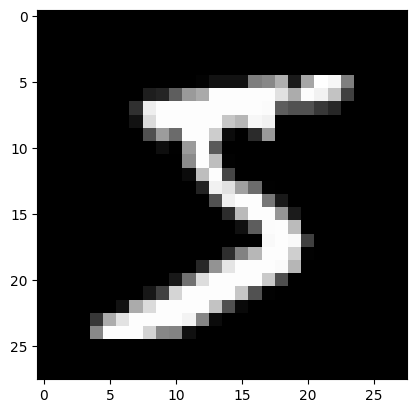

In [4]:
# 데이터 전처리 ( 데이터를 다운 받고, 변환합니다. )

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./data', train=False, transform=transforms.ToTensor())
# 위의 라이브러리를 보면 torchvision을 에서 datasets을 가져온다는 것을 알 수 있다. 그 datasets 중에서 MNIST 데이터를 가져온다는 것임.
# 구글에 torchvison 라이브러리 뒤져보면, 불러올 수 있는 각 데이터셋 종류와 작성법에 대해 써져 있음.
# 일반적으로 transform은 tranform 변수를 지정해서 다양한 list을 작성하는데, 이때 argumentation을 추가한다.
# 여기서는 꼭 필요한 image를 ToTensor만 작성하였다. 아마 데이터셋이 이미지로 저장되어 있을 텐데, 이를 Tensor 형식으로 변환한다는 뜻이다.
# 이를 train/test_dataset의 변수로 지정하였습니다.
sample_data, label = train_dataset[0]
# 샘플 데이터와 레이블을 분할. train_dataset은 그렇게 구성된 것으로 보임

plt.imshow(sample_data.reshape((28,28)), cmap='gray')
# plt.imshow(sample_data.reshape((28,28)), cmap='CMRmap')
# plt.imshow(sample_data.reshape((32,32)), cmap='gray')
# 이미지는 784이기때문에 다른 숫자를 입히면 출력이 되지 않는다. 
# 똑같은 명령어를 부르면 최하단의 명령어만 입힌다.
# cmap로 다양한 색상을 부를 수 있지만, 단지 Classification이라면 색상 feature 찾기는 의미가 없다. 우리가 보고 싶은건 단지 검은 배경 숫자 확인이니까.
print(label)

In [15]:
# 데이터 loder (전처리된 데이터셋을 배치사이즈로 자르고, 섞는 등의 작업을 하는 변수를 지정합니다. )
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle= False)

# DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
#            batch_sampler=None, num_workers=0, collate_fn=None,
#            pin_memory=False, drop_last=False, timeout=0,
#            worker_init_fn=None, *, prefetch_factor=2,
#            persistent_workers=False)
# 위는 torch.utils.data 안의 DataLoader 이다. 인터넷 찾아보면 바로 나온다.
# 또한 위는 3개의 변수만을 사용합니다.
# ??? 각 내용은 뭘 뜻하는지 제대로 뒤져보면 알겠지만, 지금은 모름. num_workers= gpu 안에 있는 연산자 개수인거 같은데...
# ??? 몇 개인지, 어디서 확인하는 지 알 수 없음.

print(f"[Dataset] train : {len(train_dataset)}, test : {len(test_dataset)}")
# 데이터 셋의 개수를 알려준다.
print(f"[DataLoader] train : {len(train_dataloader)}, test : {len(test_dataloader)}")
# 데이터 로더 프린트인데... 배치가 64크기 이니 1 배치당 64개가 들어가서, 개수 = 데이터셋 전체 개수/(배치개수) 로 구성되어 있는 것을 출력
# f 로 아마 전체 "" 안을 출력이 가능하는 것으로 본다. 그 안에 {}는 해당 안의 내용만 문자가 아닌 시스템 작동을 하는 것으로 보임

[Dataset] train : 60000, test : 10000
[DataLoader] train : 938, test : 10000


In [6]:
# 모델 구현
class MLP(nn.Module):
    def __init__(self, n_class):
        super(MLP, self).__init__()
        self.linear1= nn.Linear(784,784)
        self.linear2= nn.Linear(784,512)
        self.linear3= nn.Linear(512,256)
        self.linear4= nn.Linear(256,256)
        self.linear5= nn.Linear(256,256)
        self.linear6= nn.Linear(256,256)
        self.linear7= nn.Linear(256,256)
        self.classifier_layer = nn.Linear(256, n_class)
        self.softmax=nn.Softmax(dim=1)
# 8개의 linear 세움.
# nn의 기능ㅇ르 사용하여 linear를 세우고, 시작 노드 개수, 끝 노드 개수 선정.
# 중요한 것은 각 linear 시작과 끝이 같아야한다.
# Classifier인 8번째의 linear는 256개에서 n_class(10개)로 줄어들게 설정
# 마지막 softmax로 각 이미지에 대해 0~1 사이의 점수를 준다.
    def forward(self,x):
        x = x.view(-1, 784)
        # print(x.view(2,784))
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = torch.sigmoid(self.linear3(x))
        x = torch.sigmoid(self.linear4(x))
        x = torch.sigmoid(self.linear5(x))
        x = torch.sigmoid(self.linear6(x))
        x = torch.sigmoid(self.linear7(x))

        output = self.classifier_layer(x)
        return self.softmax(output)
# 일반적으로 우리는 linear 후 활성화 함수(sigmoid 등)을 작성해서 보여주지만, 코드 작성에는 class로 주어줬기 때문에 다르게 정의
# init 으로 linear, classifier, softmax를 self 방식으로 내가 정의 하고 싶은대로 정의했다. 
# clas 안에 foward라는 함수안에 torch.sigmoid 정의된 기능으로 사용하여 x를 지정하였다.
# x.vew(-1)는 왜 했는지 모르겠다.

# 모델 불러오기
model = MLP(n_class).to(Device)
# MLP 안에 n_class(임의 이름, 다른걸로 담아도 됨)를 지정하였기 때문에, n_class를 넣었다. classification 데이터셋의 숫자를 직접 넣어도 된다.(하지만 번거러우니 그냥 변수를 저장하고 쓰자.)
print(model)
print(MLP)



MLP(
  (linear1): Linear(in_features=784, out_features=784, bias=True)
  (linear2): Linear(in_features=784, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=256, bias=True)
  (linear6): Linear(in_features=256, out_features=256, bias=True)
  (linear7): Linear(in_features=256, out_features=256, bias=True)
  (classifier_layer): Linear(in_features=256, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)
<class '__main__.MLP'>


In [25]:
# 모델 훈련, 검증

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss = 0.0
test_loss = 0.0
epoch_train_loss = []
epoch_test_loss = []
# epoch_train/test_loss를 리스트 []형식으로 지정하였다. 마지막에 append로 train_loss/len(train_dataloader)를 넣었습니다.
for e in range(1, num_epochs+1 ):
    print(f"============[EPOCHS] {e}/{num_epochs} =============")
# train/test_loss를 사용하려 하면 먼저 정의를 해줘야하기에 loss를 0으로 만들었다.

    #train
    model.train()
    for data, label in tqdm(train_dataloader):
        data = data.to(Device)
        label = label.to(Device)
        output = model (data)
        loss = loss_func(output, label)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_train_loss.append(train_loss/len(train_dataloader))
    print(f"Train Loss: {train_loss/len(train_dataloader): .6f}")
# data(image.Tensor), label를 device에 넣는다.
# loss_func(nn.Crossentropyloss)에 output(예측), label(정답, target) 두개를 넣어서 값을 출력한다.
# nn.CrossLoss 안의 item을 추출해서 넣는다.( 정확히 뭐를 뽑는 지는 모르겠음 ), 매 에폭마다 더해서 넣어줌.
# optimzer를 일단 zero_grad써서 초기화를 하여 주어서 매 에폭마다 훈련시킨다.
# nn.CrossLoss 안의 backward 기능(함수)를 가져와서 진행한다.
# ???. optimizer(Adam)의 기능 step을 사용하여서 진행한다. (근데 step이 뭐지?)

    with torch.no_grad(): # autograd 엔진 비활성화
        model.eval() # dropout 비활성화 시켜줌
        test_acc = 0.0
        for data, label in tqdm(test_dataloader):
            data = data.to(Device)
            label = label.to(Device)
            output = model(data)
            loss = loss_func(output, label)
            test_loss += loss.item()
            preds = torch.argmax(output, dim=1)
            test_acc += preds.eq(label).sum()
    epoch_test_loss.append(test_loss/len(test_dataloader))
    print(f"Test Loss: {test_loss/len(test_dataloader) : .6f}")
    print(f"[Test RESULT] {(test_acc/len(test_dataloader))*100: .3f}%")
# torch.no_grad는 더이상 grad 는 하지 않는 것.
# preds= argmax(output, dim=1), argmax는 나온 결과 중 최대값 1개를 찾는 건데, 최대값이 몇번째인지를 찾는 것이다. dim=1은 1개로 나오는 거 일...듯하다
# test acc는 preds의 label의 위치가 같다면 그 개수를 더하는 것

============[EPOCHS] 1/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss:  1.628466


  0%|          | 0/10000 [00:00<?, ?it/s]

Test Loss:  1.633242
[Test RESULT]  82.780%
============[EPOCHS] 2/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss:  3.256529


  0%|          | 0/10000 [00:00<?, ?it/s]

Test Loss:  3.270171
[Test RESULT]  82.440%
============[EPOCHS] 3/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss:  4.883299


  0%|          | 0/10000 [00:00<?, ?it/s]

Test Loss:  4.907192
[Test RESULT]  82.430%
============[EPOCHS] 4/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss:  6.507881


  0%|          | 0/10000 [00:00<?, ?it/s]

Test Loss:  6.541271
[Test RESULT]  82.700%
============[EPOCHS] 5/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss:  8.132634


  0%|          | 0/10000 [00:00<?, ?it/s]

Test Loss:  8.176821
[Test RESULT]  82.500%
============[EPOCHS] 6/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss:  9.756865


  0%|          | 0/10000 [00:00<?, ?it/s]

Test Loss:  9.810587
[Test RESULT]  82.750%
============[EPOCHS] 7/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss:  11.381239


  0%|          | 0/10000 [00:00<?, ?it/s]

Test Loss:  11.445903
[Test RESULT]  82.540%
============[EPOCHS] 8/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss:  13.005090


  0%|          | 0/10000 [00:00<?, ?it/s]

Test Loss:  13.077253
[Test RESULT]  82.990%
============[EPOCHS] 9/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss:  14.628103


  0%|          | 0/10000 [00:00<?, ?it/s]

Test Loss:  14.706509
[Test RESULT]  83.180%
============[EPOCHS] 10/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss:  16.249914


  0%|          | 0/10000 [00:00<?, ?it/s]

Test Loss:  16.336458
[Test RESULT]  83.090%


In [ ]:
plt.plot(epoch_train_loss, 'b')
plt.plot(epoch_test_loss,'r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()